In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
#import contextily as ctx
import geoplot.crs as gcrs
import cartopy.crs as ccrs
import cartopy
import geoplot as gplt
import matplotlib as mpl
from matplotlib import pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn")

In [4]:
us_pop = pd.read_excel("https://www2.census.gov/programs-surveys/popest/tables/2010-2018/state/totals/nst-est2018-01.xlsx",
                       skiprows=[0,1,2], skipfooter=5).dropna()                 #readin the dataset, skip irrelevant rows, drop empty rows
us_pop.rename(columns={"Unnamed: 0":"Geographic Area"}, inplace=True)           #rename the geographic area name column
us_pop["Geographic Area"] = us_pop["Geographic Area"].str.replace(".", "")      #remove extra . in the state names

In [5]:
us_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 57
Data columns (total 12 columns):
Geographic Area    57 non-null object
Census             57 non-null float64
Estimates Base     57 non-null float64
2010               57 non-null float64
2011               57 non-null float64
2012               57 non-null float64
2013               57 non-null float64
2014               57 non-null float64
2015               57 non-null float64
2016               57 non-null float64
2017               57 non-null float64
2018               57 non-null float64
dtypes: float64(11), object(1)
memory usage: 5.8+ KB


In [7]:
subpart_emitters = pd.read_csv("Data/Subpart_Summary_Emitters.CSV")

In [8]:
subpart_emitters.head()

,V_GHG_EMITTER_SUBPART.ADDRESS1,V_GHG_EMITTER_SUBPART.ADDRESS2,V_GHG_EMITTER_SUBPART.CITY,V_GHG_EMITTER_SUBPART.CO2E_EMISSION,V_GHG_EMITTER_SUBPART.COUNTY,V_GHG_EMITTER_SUBPART.FACILITY_ID,V_GHG_EMITTER_SUBPART.GAS_CODE,V_GHG_EMITTER_SUBPART.GAS_NAME,V_GHG_EMITTER_SUBPART.LATITUDE,V_GHG_EMITTER_SUBPART.LONGITUDE,V_GHG_EMITTER_SUBPART.STATE,V_GHG_EMITTER_SUBPART.STATE_NAME,V_GHG_EMITTER_SUBPART.SUBPART_CATEGORY,V_GHG_EMITTER_SUBPART.SUBPART_NAME,V_GHG_EMITTER_SUBPART.SUBPART_TYPE,V_GHG_EMITTER_SUBPART.YEAR,V_GHG_EMITTER_SUBPART.ZIP,V_GHG_EMITTER_SUBPART.FACILITY_NAME,V_GHG_EMITTER_SUBPART.GHG_QUANTITY,V_GHG_EMITTER_SUBPART.COUNTY_FIPS
0,555 TOWNSEND RD,NaN,COCOA,118.306,Brevard,1006808,N2O,Nitrous Oxide,28.3661,-80.7947,FL,FLORIDA,Electricity Generation,D,E,2011,32926,Oleander Power Project,0.397,12009.0
1,6801 E 2ND ST,NaN,LONG BEACH,22.200,Los Angeles,1006097,CO2,Carbon Dioxide,33.7639,-118.0942,CA,CALIFORNIA,Stationary Combustion,C,E,2018,90803,Haynes Generating Station,22.200,6037.0
2,700 S CONEJOS ST,NaN,COLORADO SPRINGS,3078.500,El Paso,1001465,CH4,Methane,38.8244,-104.8331,CO,COLORADO,Electricity Generation,D,E,2018,80903,Martin Drake,123.140,8041.0
3,529 E. 135th Street,NaN,ROMEOVILLE,1.788,Will,1001523,N2O,Nitrous Oxide,41.6334,-88.0626,IL,ILLINOIS,Stationary Combustion,C,E,2018,60446,Will County,0.006,17197.0
4,21225 RIVERWOOD AVE,NaN,NOBLESVILLE,329.290,Hamilton,1001542,N2O,Nitrous Oxide,40.0969,-85.9714,IN,INDIANA,Electricity Generation,D,E,2018,46060,Noblesville,1.105,18057.0


In [9]:
#clean the column names
column_names = []
for i in range(len(subpart_emitters.columns)):
    column_names.append(subpart_emitters.columns.str.split(".")[i][1].lower())
    
subpart_emitters.columns = column_names

In [10]:
subpart_emitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249777 entries, 0 to 249776
Data columns (total 20 columns):
address1            228196 non-null object
address2            0 non-null float64
city                249777 non-null object
co2e_emission       249777 non-null float64
county              240623 non-null object
facility_id         249777 non-null int64
gas_code            249777 non-null object
gas_name            249777 non-null object
latitude            249777 non-null float64
longitude           249777 non-null float64
state               249777 non-null object
state_name          249777 non-null object
subpart_category    249777 non-null object
subpart_name        249777 non-null object
subpart_type        249777 non-null object
year                249777 non-null int64
zip                 249777 non-null int64
facility_name       249777 non-null object
ghg_quantity        247759 non-null float64
county_fips         240595 non-null float64
dtypes: float64(6), int64(3), o

In [11]:
emitters = subpart_emitters[["co2e_emission", "gas_code", "gas_name", "latitude", "longitude", "state", "state_name",
                             "subpart_category", "subpart_name", "year", "ghg_quantity"]]
emitters.head()

,co2e_emission,gas_code,gas_name,latitude,longitude,state,state_name,subpart_category,subpart_name,year,ghg_quantity
0,118.306,N2O,Nitrous Oxide,28.3661,-80.7947,FL,FLORIDA,Electricity Generation,D,2011,0.397
1,22.200,CO2,Carbon Dioxide,33.7639,-118.0942,CA,CALIFORNIA,Stationary Combustion,C,2018,22.200
2,3078.500,CH4,Methane,38.8244,-104.8331,CO,COLORADO,Electricity Generation,D,2018,123.140
3,1.788,N2O,Nitrous Oxide,41.6334,-88.0626,IL,ILLINOIS,Stationary Combustion,C,2018,0.006
4,329.290,N2O,Nitrous Oxide,40.0969,-85.9714,IN,INDIANA,Electricity Generation,D,2018,1.105


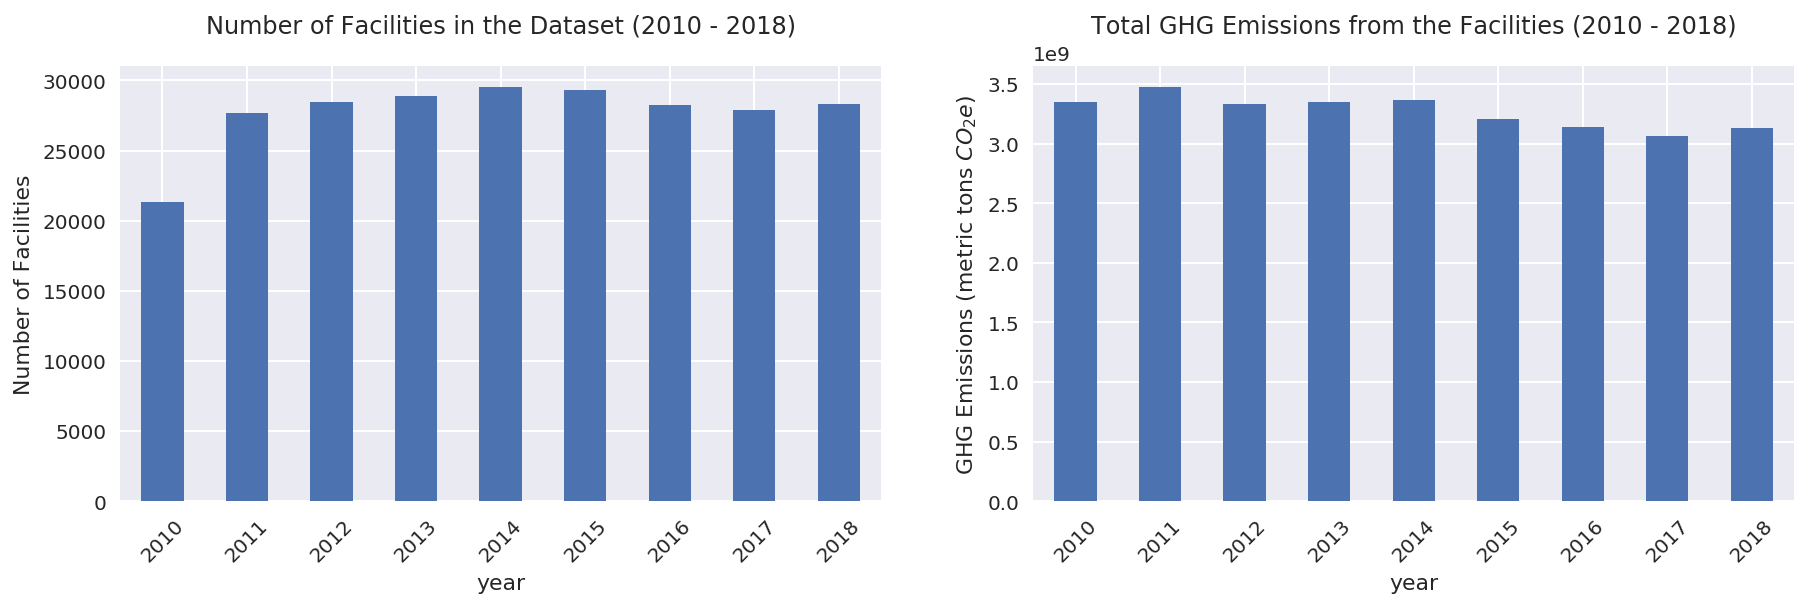

In [12]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=2)

emitters.groupby("year").co2e_emission.count().plot.bar(ax=ax[0])
emitters.groupby("year").co2e_emission.sum().plot.bar(ax=ax[1])

ax[0].set_title("Number of Facilities in the Dataset (2010 - 2018)", y=1.05)
ax[0].set_ylabel("Number of Facilities")
ax[0].tick_params(axis="x", rotation=45)

ax[1].set_title("Total GHG Emissions from the Facilities (2010 - 2018)", y=1.05)
ax[1].set_ylabel("GHG Emissions (metric tons $CO_2e$)")
ax[1].tick_params(axis="x", rotation=45)

plt.subplots_adjust(wspace=0.2);
#plt.tight_layout()

In [13]:
emitters_2018 = emitters[emitters.year == 2018]
emitters_2018.head()

,co2e_emission,gas_code,gas_name,latitude,longitude,state,state_name,subpart_category,subpart_name,year,ghg_quantity
1,22.200,CO2,Carbon Dioxide,33.7639,-118.0942,CA,CALIFORNIA,Stationary Combustion,C,2018,22.200
2,3078.500,CH4,Methane,38.8244,-104.8331,CO,COLORADO,Electricity Generation,D,2018,123.140
3,1.788,N2O,Nitrous Oxide,41.6334,-88.0626,IL,ILLINOIS,Stationary Combustion,C,2018,0.006
4,329.290,N2O,Nitrous Oxide,40.0969,-85.9714,IN,INDIANA,Electricity Generation,D,2018,1.105
5,202.800,CO2,Carbon Dioxide,41.8081,-90.2345,IA,IOWA,Stationary Combustion,C,2018,202.800


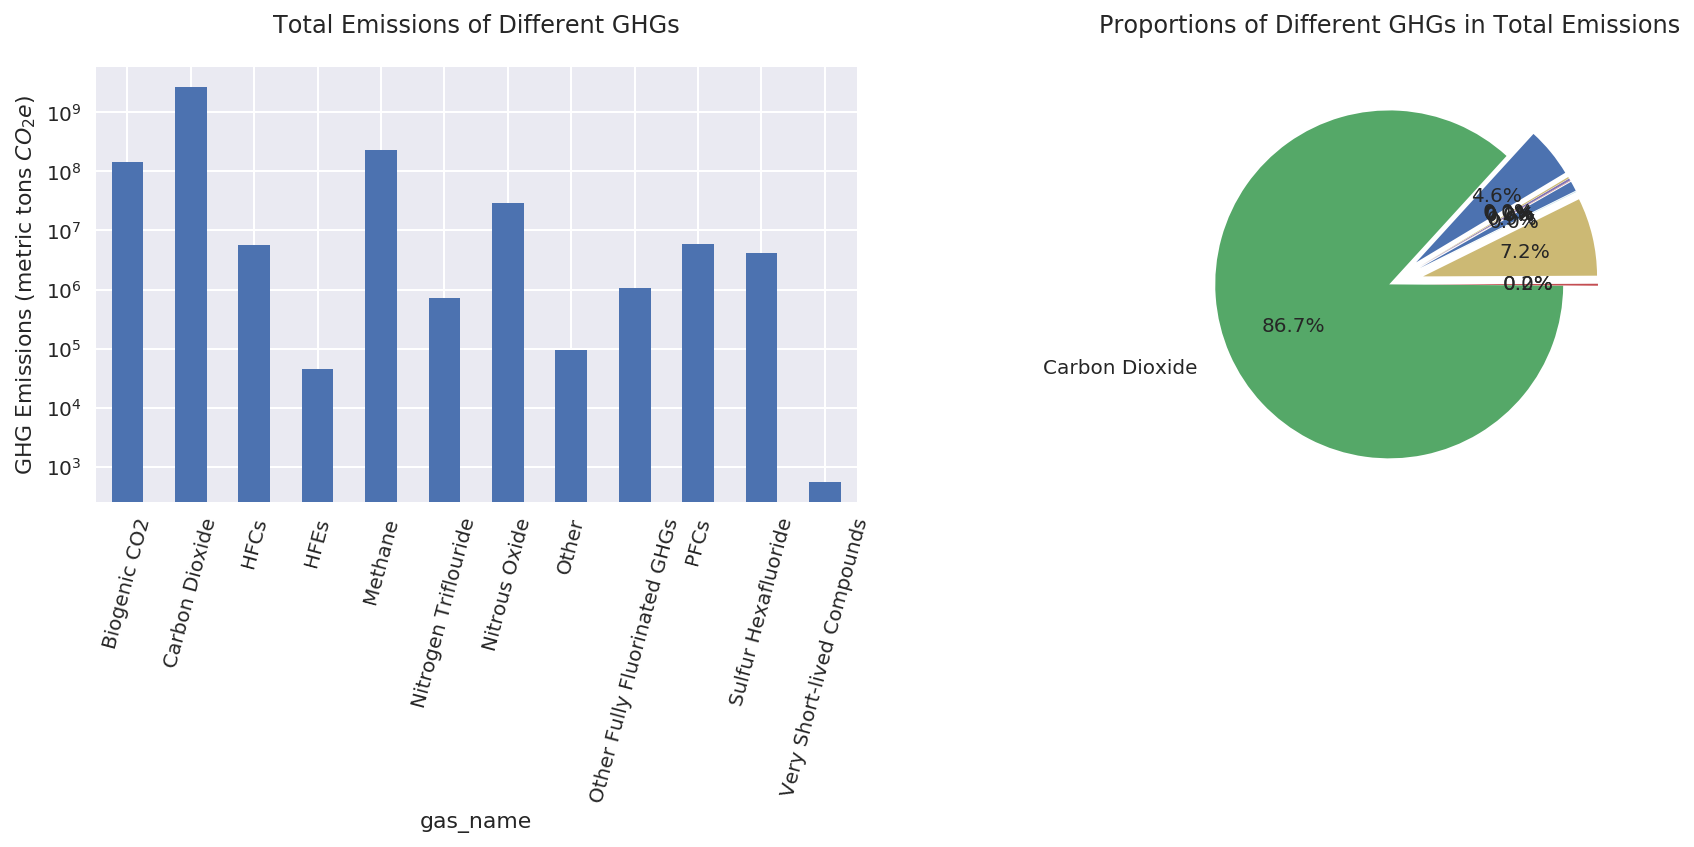

In [45]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=2)

explode = np.ones(emitters_2018.gas_name.nunique()) * 0.2
explode[1] = 0
labels = [""] * emitters_2018.gas_name.nunique()
labels[1] = "Carbon Dioxide"

emitters_2018.groupby("gas_name").co2e_emission.sum().plot.bar(ax=ax[0])
emitters_2018.groupby("gas_name").co2e_emission.sum().plot.pie(ax=ax[1], startangle=31, labeldistance=1.2,
                                                               explode=explode, autopct='%1.1f%%', labels=labels)

ax[0].set_title("Total Emissions of Different GHGs", y=1.05)
ax[0].set_ylabel("GHG Emissions (metric tons $CO_2e$)")
ax[0].set_yscale("log")
ax[0].tick_params(axis="x", rotation=75)
#ax[0].grid(axis="y", linestyle=":")

ax[1].set_title("Proportions of Different GHGs in Total Emissions", y=1.05)
ax[1].set_ylabel("")
# ax[1].tick_params(axis="x", rotation=45)

plt.subplots_adjust(wspace=0.2);

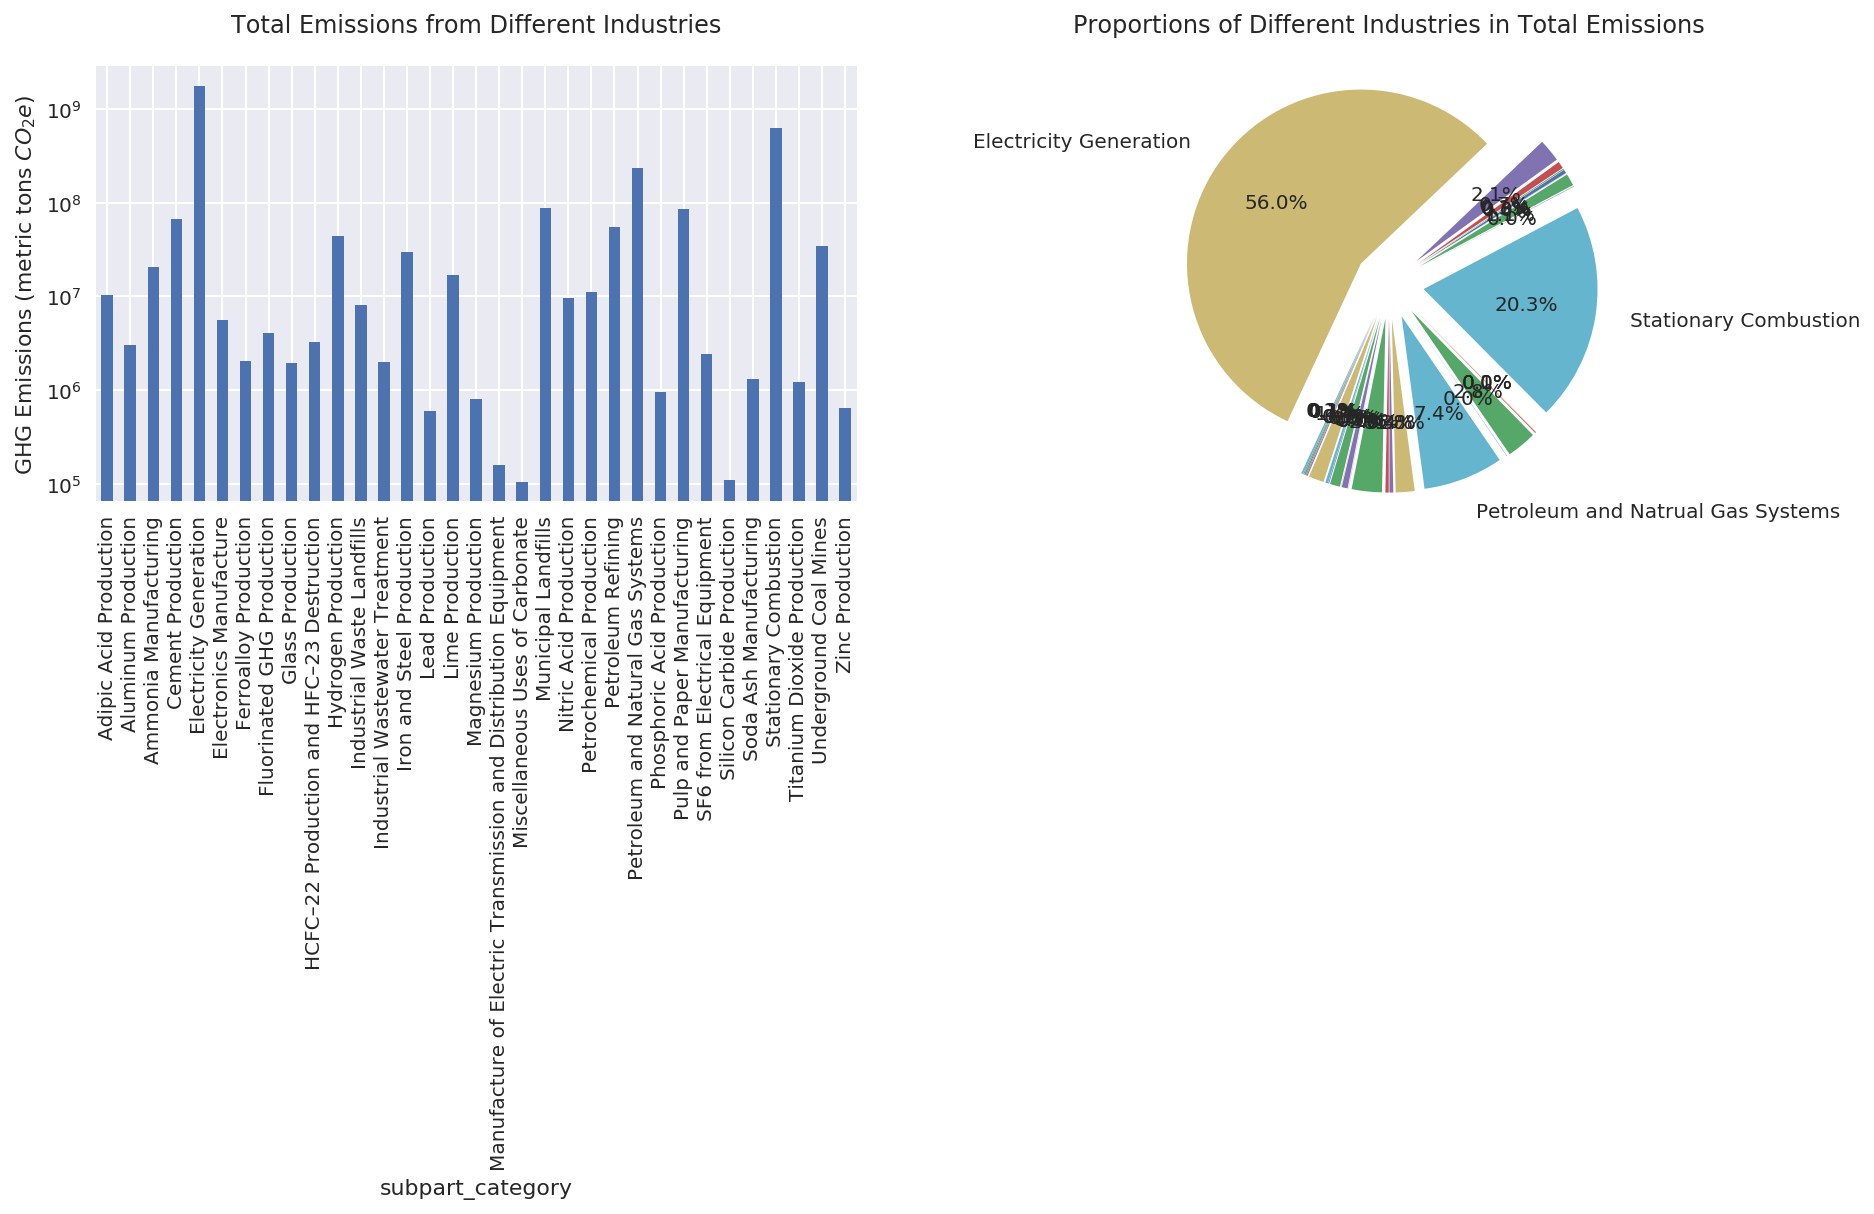

In [50]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=2)

explode = np.ones(emitters_2018.subpart_category.nunique()) * 0.2
# explode[1] = 0
labels = [""] * emitters_2018.subpart_category.nunique()
labels[4] = "Electricity Generation"
labels[-4] = "Stationary Combustion"
labels[-10] = "Petroleum and Natrual Gas Systems"

emitters_2018.groupby("subpart_category").co2e_emission.sum().plot.bar(ax=ax[0])
emitters_2018.groupby("subpart_category").co2e_emission.sum().plot.pie(ax=ax[1], startangle=32, labeldistance=1.2,
                                                                       explode=explode, autopct='%1.1f%%', labels=labels)

ax[0].set_title("Total Emissions from Different Industries", y=1.05)
ax[0].set_ylabel("GHG Emissions (metric tons $CO_2e$)")
ax[0].set_yscale("log")
#ax[0].tick_params(axis="x", rotation=80)
#ax[0].grid(axis="y", linestyle=":")

ax[1].set_title("Proportions of Different Industries in Total Emissions", y=1.05)
ax[1].set_ylabel("")
# ax[1].tick_params(axis="x", rotation=45)

plt.subplots_adjust(wspace=0.2);

In [16]:
us_states = gpd.read_file("Data/GIS_Data/tl_2019_us_state.shp")

In [17]:
us_states.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266231560,489271086,+38.6472854,-080.6183274,"POLYGON ((-81.747254 39.095379, -81.746354 39...."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138947364717,31362872853,+28.4574302,-082.4091477,"(POLYGON ((-86.38864599999999 30.994181, -86.3..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143779863817,6215723896,+40.1028754,-089.1526108,"POLYGON ((-91.185295 40.637803, -91.1751 40.64..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206230065476,18942261495,+46.3159573,-094.1996043,"POLYGON ((-96.784381 46.63050399999999, -96.78..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151726296,6979340970,+38.9466584,-076.6744939,"POLYGON ((-77.45880799999999 39.22027, -77.458..."


In [18]:
# define Albers Equal Area projection in cartopy format
proj_aea_contig_us = ccrs.AlbersEqualArea(central_longitude=-96.0,
                                          central_latitude=37.5,
                                          standard_parallels=(29.5, 45.5))

# define Albers Equal Area projection in proj4 format
crs_aea_contig_us = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"

In [19]:
emitters_2018_gdf = gpd.GeoDataFrame(emitters_2018, crs=crs_aea_contig_us,
                                     geometry=gpd.points_from_xy(emitters_2018.longitude, emitters_2018.latitude))

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


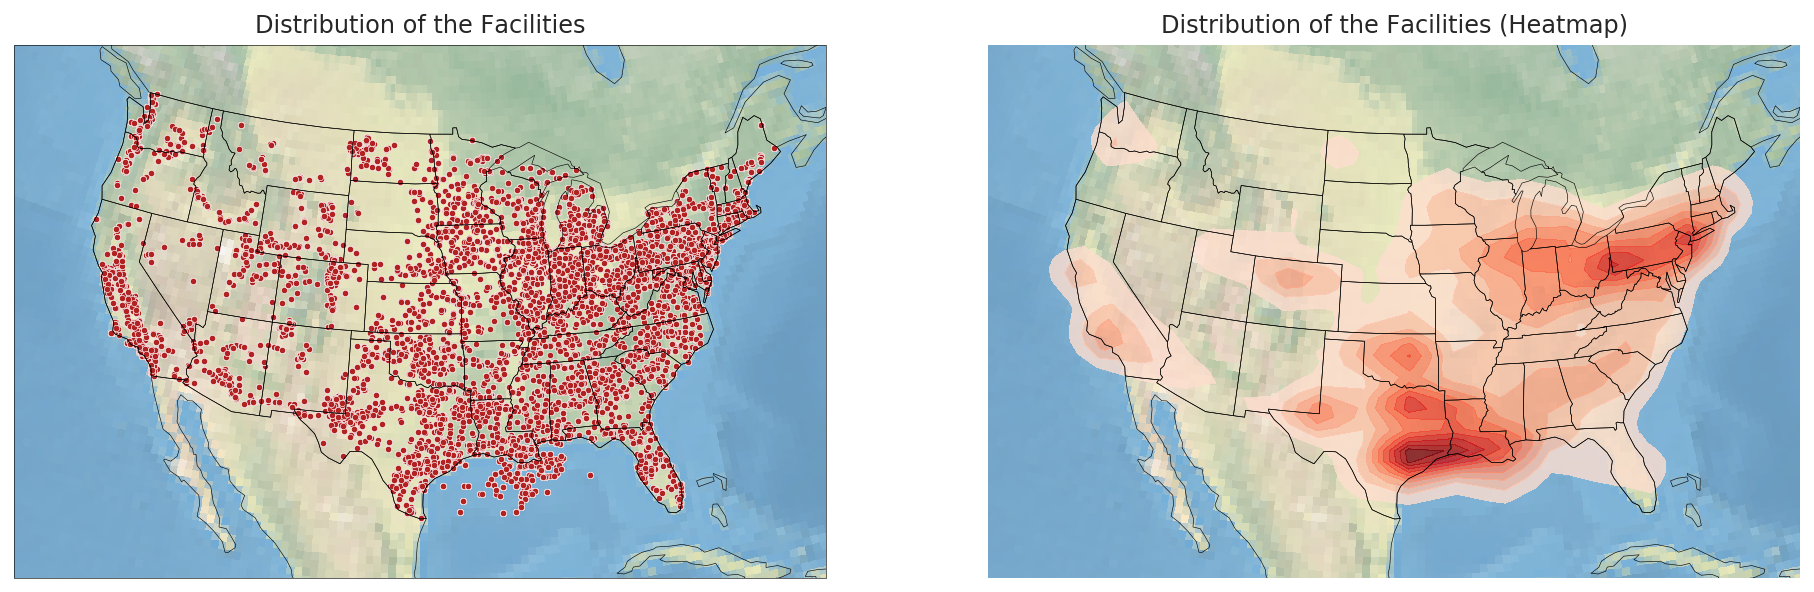

In [20]:
fig, ax = plt.subplots(figsize=(16,6), ncols=2, subplot_kw={'projection': proj_aea_contig_us})

emitters_2018.plot.scatter("longitude", "latitude", ax=ax[0], transform=ccrs.PlateCarree(),
                           c="firebrick", s=10, edgecolor="w")
gplt.kdeplot(emitters_2018_gdf, cmap='Reds', shade=True, ax=ax[1], alpha=0.8)

for i in range(2):
    ax[i].set_extent([-123, -72, 20, 52])
    ax[i].stock_img()
    ax[i].coastlines()
    ax[i].add_feature(cartopy.feature.BORDERS)
    ax[i].add_feature(cartopy.feature.STATES)

ax[0].set_title("Distribution of the Facilities")
ax[1].set_title("Distribution of the Facilities (Heatmap)");

In [21]:
us_pop = pd.read_excel("https://www2.census.gov/programs-surveys/popest/tables/2010-2018/state/totals/nst-est2018-01.xlsx",
                       skiprows=[0,1,2], skipfooter=5).dropna()                 #readin the dataset, skip irrelevant rows, drop empty rows
us_pop.rename(columns={"Unnamed: 0":"Geographic Area"}, inplace=True)           #rename the geographic area name column
us_pop["Geographic Area"] = us_pop["Geographic Area"].str.replace(".", "")      #remove extra . in the state names

In [22]:
us_state_pop_2018 = us_pop.drop(range(5))[["Geographic Area", 2018]]
us_state_pop_2018.columns = ["state", "pop_2018"]
us_state_pop_2018["state_name"] = us_state_pop_2018.state.str.upper()
us_state_pop_2018.head()

,state,pop_2018,state_name
5,Alabama,4887871.0,ALABAMA
6,Alaska,737438.0,ALASKA
7,Arizona,7171646.0,ARIZONA
8,Arkansas,3013825.0,ARKANSAS
9,California,39557045.0,CALIFORNIA


In [23]:
emitters_2018_state = emitters_2018.groupby(["state_name", "state"]).co2e_emission.sum().to_frame().reset_index()

In [24]:
emitters_2018_state = emitters_2018_state.merge(us_state_pop_2018, how="left", on="state_name")
emitters_2018_state.head()

,state_name,state_x,co2e_emission,state_y,pop_2018
0,ALABAMA,AL,1.010738e+08,Alabama,4887871.0
1,ALASKA,AK,1.980513e+07,Alaska,737438.0
2,ARIZONA,AZ,5.624347e+07,Arizona,7171646.0
3,ARKANSAS,AR,5.377236e+07,Arkansas,3013825.0
4,CALIFORNIA,CA,1.078876e+08,California,39557045.0


In [25]:
emitters_2018_state.drop("state_y", axis=1, inplace=True)
emitters_2018_state.rename(columns={"state_x":"state_code"}, inplace=True)
emitters_2018_state["emission_per_capita"] = emitters_2018_state.co2e_emission / emitters_2018_state.pop_2018
emitters_2018_state.head()

,state_name,state_code,co2e_emission,pop_2018,emission_per_capita
0,ALABAMA,AL,1.010738e+08,4887871.0,20.678496
1,ALASKA,AK,1.980513e+07,737438.0,26.856673
2,ARIZONA,AZ,5.624347e+07,7171646.0,7.842477
3,ARKANSAS,AR,5.377236e+07,3013825.0,17.841899
4,CALIFORNIA,CA,1.078876e+08,39557045.0,2.727394


In [118]:
us_states = gpd.read_file("Data/GIS_Data/tl_2019_us_state.shp")

In [164]:
#us_states.head()

In [26]:
us_states = us_states[["STUSPS", "NAME", "ALAND", "AWATER", "geometry"]]
us_states_ghg_2018 = us_states.merge(emitters_2018_state, how="left", left_on="STUSPS", right_on="state_code")
us_states_ghg_2018.head()

,STUSPS,NAME,ALAND,AWATER,geometry,state_name,state_code,co2e_emission,pop_2018,emission_per_capita
0,WV,West Virginia,62266231560,489271086,"POLYGON ((-81.747254 39.095379, -81.746354 39....",WEST VIRGINIA,WV,7.997831e+07,1805832.0,44.288898
1,FL,Florida,138947364717,31362872853,"(POLYGON ((-86.38864599999999 30.994181, -86.3...",FLORIDA,FL,1.481110e+08,21299325.0,6.953791
2,IL,Illinois,143779863817,6215723896,"POLYGON ((-91.185295 40.637803, -91.1751 40.64...",ILLINOIS,IL,1.059435e+08,12741080.0,8.315109
3,MN,Minnesota,206230065476,18942261495,"POLYGON ((-96.784381 46.63050399999999, -96.78...",MINNESOTA,MN,4.851275e+07,5611179.0,8.645732
4,MD,Maryland,25151726296,6979340970,"POLYGON ((-77.45880799999999 39.22027, -77.458...",MARYLAND,MD,2.394053e+07,6042718.0,3.961882


/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


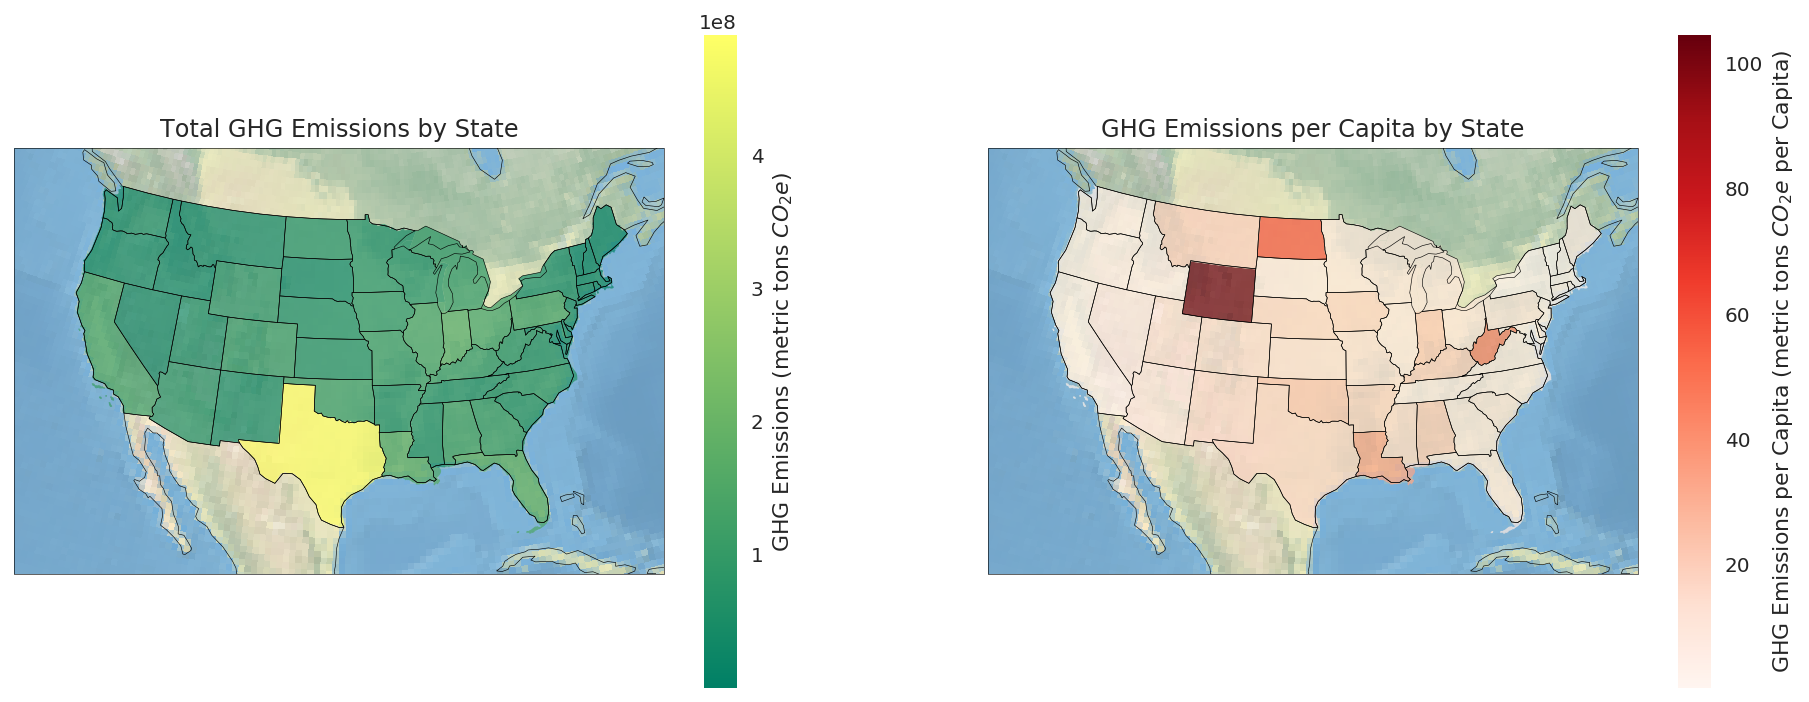

In [27]:
fig, ax = plt.subplots(figsize=(16,6), ncols=2, subplot_kw={'projection': proj_aea_contig_us})

us_states_ghg_2018.to_crs(crs_aea_contig_us).plot(column='co2e_emission', ax=ax[0], cmap="summer", legend=True, alpha=0.7)
us_states_ghg_2018.to_crs(crs_aea_contig_us).plot(column='emission_per_capita', ax=ax[1], cmap="Reds", legend=True, alpha=0.7)

for i in range(2):
    ax[i].set_extent([-123, -72, 20, 52])
    ax[i].stock_img()
    ax[i].coastlines()
    ax[i].add_feature(cartopy.feature.BORDERS)
    ax[i].add_feature(cartopy.feature.STATES)
    
ax[0].set_title("Total GHG Emissions by State")
ax[1].set_title("GHG Emissions per Capita by State")
fig.axes[2].set_ylabel("GHG Emissions (metric tons $CO_2e$)")
fig.axes[3].set_ylabel("GHG Emissions per Capita (metric tons $CO_2e$ per Capita)");

In [51]:
m = folium.Map(location=[37.5, -96], zoom_start=4, control_scale=True)

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'

folium.Choropleth(
    geo_data=state_geo,
    name='Total GHG Emissions',
    data=us_states_ghg_2018,
    columns=['STUSPS', 'co2e_emission'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total GHG Emissions (metric tons CO2e)'
).add_to(m)

folium.Choropleth(
    geo_data=state_geo,
    name='GHG Emissions per Capita',
    data=us_states_ghg_2018,
    columns=['STUSPS', 'emission_per_capita'],
    key_on='feature.id',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='GHG Emissions per Capita (metric tons CO2e per Capita)',
    show=False
).add_to(m)

folium.LayerControl().add_to(m)

m

In [26]:
us_cz = gpd.read_file("Data/GIS_Data/US_CZ_2001_2025_A1FI.shp")

In [27]:
us_cz.rename(columns={"Legend__Cl": "climate_zone"}, inplace=True)
us_cz["cz_main"] = us_cz.climate_zone.str[0]
us_cz = us_cz[["climate_zone", "cz_main", "geometry"]]
us_cz.head()

,climate_zone,cz_main,geometry
0,Af,A,"MULTIPOLYGON (((-67.00000 18.50000, -65.87822 ..."
1,Am,A,"MULTIPOLYGON (((-67.47214 18.32609, -67.48090 ..."
2,As,A,"POLYGON ((-81.50000 26.00000, -81.81568 26.000..."
3,Aw,A,"POLYGON ((-80.50000 25.00000, -81.06164 25.000..."
4,BWk,B,"MULTIPOLYGON (((-109.00000 31.50000, -109.0000..."


In [55]:
us_cz_main = us_cz.dissolve(by="cz_main")
us_cz_main.drop("climate_zone", axis=1, inplace=True)
us_cz_main.reset_index()
#us_cz_main["code_fot_plot"] = range(5)

In [58]:
#us_cz_main.plot(column="code_for_plot")

In [29]:
# us_cz_main_ghg_2018 = gpd.sjoin(us_cz_main.to_crs({'init': 'epsg:4326'}), emitters_2018_gdf.to_crs({'init': 'epsg:4326'}), how="left", op="contains")
# us_cz_main_ghg_2018.reset_index(inplace=True)
# #us_cz_main_ghg_2018.dissolve(by="index", aggfunc="sum")
# us_cz_main_ghg_2018["index"].value_counts()

In [60]:
#us_cz_main_ghg_2018.groupby("index").co2e_emission.sum().to_frame().reset_index()

In [59]:
#emitters_2018_gdf

<img src="Climate_Zone.png" alt="Climate Zone" width="800">